# Script to create composites of SST gradient based on ENSO phase

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import xarray as xr

from grad_funcs import get_gs_coords_alltime,get_total_gradient
from global_land_mask import globe

In [65]:
## months to perform analysis, for full year set analysis_months = range(1,13)

analysis_months = [2]
figtitle = 'SHF_ERA5_Feb_25deg.png'


#dslink = '/Users/noahrosenberg/Downloads/era5_sst_1940_2022_1deg.nc'
dslink = '/Users/noahrosenberg/Downloads/era5_sst_shf_dec_jan_feb1940_2023_025deg.nc'
unit_conv = 1/1000 #unit scaling for the gradient, set to 1/1000 for m**-1 or 100 for (100 km)**-1
nroll = 1


#ds = xr.load_dataset(f'{dslink}',engine='netcdf4')
ds = xr.load_dataset(f'{dslink}',engine='netcdf4')
ds = ds.where(ds.time.dt.month.isin(analysis_months),drop=True)

/Users/noahrosenberg/miniconda3/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [66]:
ds.load()

sst = ds.sshf # set to data variable you want to look at

lons = ds.longitude #rename based on latitude/longitude variables
lats = ds.latitude
latname = 'latitude' #also rename these for grad calculation function
lonname = 'longitude'

x = lons.to_numpy()
x = np.where(x>180,x-360,x)
x,y = np.meshgrid(x,lats)
sst = sst.where(globe.is_ocean(y,x)) ## mask out land values 

nino_dates = np.load('ninodates.npy',allow_pickle=True) #read in files generated from Nino3.4.ipynb containing ENSO dates
nina_dates = np.load('ninadates.npy',allow_pickle=True)

In [67]:
## get dates from Nino script and dataarray into same format



nino_months = nino_dates.astype('datetime64[M]')

year0 = sst.time.dt.year.min()
year0 = int(year0)

nino_indices = nino_months.astype('int')+(1970-year0)*12

sst_month_indices = (sst.time.dt.year-year0)*12 + sst.time.dt.month

sst_nino = sst.where(sst_month_indices.isin(nino_indices),drop=True)
sst_nino = sst_nino

/Users/noahrosenberg/miniconda3/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/Users/noahrosenberg/miniconda3/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


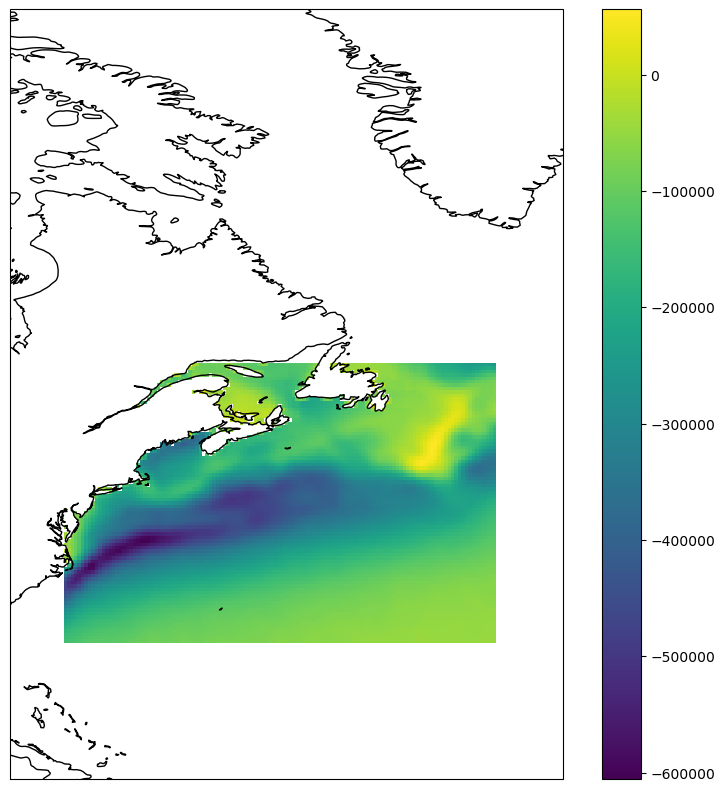

In [68]:
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
im = ax.pcolormesh(lons,lats,sst_nino.mean('time').where(globe.is_ocean(y,x)),transform=ccrs.PlateCarree())
#im2 = ax.contour(sst.lon,sst.lat,tot_grad.mean('time'),levels=(1,288),c='r')

ax.set_extent((-80,-40,20,75))
plt.colorbar(im,ax=ax)
ax.coastlines()

In [69]:


nina_months = nina_dates.astype('datetime64[M]')

year0 = sst.time.dt.year.min()
year0 = int(year0)

nina_indices = nina_months.astype('int')+(1970-year0)*12

sst_month_indices = (sst.time.dt.year-year0)*12 + sst.time.dt.month

sst_nina = sst.where(sst_month_indices.isin(nina_indices),drop=True)

/Users/noahrosenberg/miniconda3/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/Users/noahrosenberg/miniconda3/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [70]:
from matplotlib import colors
from cartopy import feature
from scipy import stats


# plot difference in gradients between 2 composites

nina_grad = get_total_gradient(sst_nina,nroll,latname=latname,lonname=lonname)*unit_conv
nino_grad = get_total_gradient(sst_nino,nroll,latname=latname,lonname=lonname)*unit_conv

nino_grad_mean = nino_grad.mean('time')
nina_grad_mean = nina_grad.mean('time')
nina_grad_std = nina_grad.std('time')

pvals = np.zeros((len(lons),len(lats)))

for i in range(len(lons)):
    for j in range(len(lats)):
        pvals[i,j] = stats.kstest(nino_grad[:,j,i].to_numpy(), nina_grad[:,j,i].to_numpy()).pvalue


tot_grad = get_total_gradient(sst,nroll,latname=latname,lonname=lonname)*unit_conv

tot_grad_mean = tot_grad.mean('time')
tot_grad_std = tot_grad.std('time')

#nino_diff_zscore = abs(nino_grad_mean-nina_grad_mean)/nina_grad_std


#pvals = norm.sf(abs(nino_diff_zscore)) < 0.05
                               
        

In [71]:
nino_grad_annual = nino_grad.groupby('time.year').mean('time')
nina_grad_annual = nina_grad.groupby('time.year').mean('time')

nino_years = nino_grad_annual.year.data
nina_years = nina_grad_annual.year.data

import random

sig = nino_grad_mean-nina_grad_mean


for i in range(5):
    rs_nino = np.random.choice(nino_years,10)
    rs_nina = np.random.choice(nina_years,10)
    comp = nino_grad_annual.where(nino_grad_annual.year.isin(rs_nino)).mean('year') - nina_grad_annual.where(nina_grad_annual.year.isin(rs_nina)).mean('year')
    sig = sig.where(np.sign(comp) == np.sign(sig))
    
    

/Users/noahrosenberg/miniconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  result = super().contourf(*args, **kwargs)


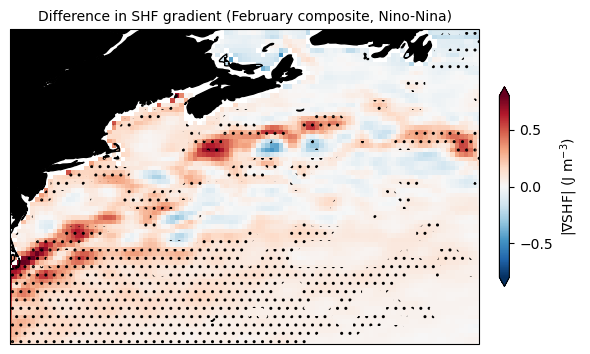

In [75]:
fig,ax = plt.subplots(figsize=(6,5),subplot_kw={'projection':ccrs.PlateCarree()})
im = ax.pcolormesh(lons,lats,
                   nino_grad_mean-nina_grad_mean,
                   transform=ccrs.PlateCarree(),
                   #vmin=0,vmax=0.03,
                   cmap="RdBu_r",norm=colors.CenteredNorm(0,0.8))#(0,0.0005))#,cmap='RdBu_r')

stip = ax.contourf(lons,lats,sig,transform=ccrs.PlateCarree(),
                    hatches = ['..'],alpha=0,edgecolor='gray')

ax.coastlines()
ax.add_feature(feature.LAND,facecolor='k')#,transform=ccrs.PlateCarree())


ax.set_extent((-76,-50,31,48))
plt.colorbar(im,ax=ax,fraction=0.02, pad=0.04,extend='both',
             label = r'$|\nabla$SHF| (J m$^{-3}$)')#' (100 km)$^{-1}$)')
             #label = r'$|\nabla$SST| ($\degree$ C (100 km)$^{-1}$)')
ax.set_title('Difference in SHF gradient (February composite, Nino-Nina)',fontsize=10)
plt.tight_layout()
plt.savefig(figtitle)

plt.show()

In [73]:
sig

<xarray.DataArray (latitude: 81, longitude: 125)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.19491679, 0.09314517, 0.08769959, ...,        nan,        nan,
        0.16949551],
       [0.17799112, 0.07307413, 0.07146151, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * longitude  (longitude) float32 -76.0 -75.75 -75.5 ... -45.5 -45.25 -45.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0